---

## **Introduction**

### **One-Step TD for State Value Estimation in Grid World**

This project implements **Off-Policy Monte Carlo Control** in a GridWorld environment.

<br>

In this notebook, I will evaluate the value of each state using the one-step Temporal Difference (TD) method. The policy used will sample each action with equal probability.

TD combines **bootstrapping** from Dynamic Programming (DP) with **sampling** from Monte Carlo (MC) methods.  
It generates one-step data through direct sampling and updates the current state's value based on the estimated value of the subsequent state.

Unlike the Monte Carlo method, which requires completing an entire episode before updating values, TD can update immediately after each timestep.  
This feature makes TD suitable for **continuing tasks**.  

Additionally, TD leverages estimated values of nearby future states from the current state, resulting in **less variance** compared to Monte Carlo methods.

While DP requires a model of the environment (i.e., knowledge of the transition probabilities and rewards), TD can compute values directly through trial and error without requiring prior knowledge of the environment.  

This makes TD highly versatile for tasks where the model is unknown.

<br>

---

The grid world map is structured as follows:

- The game `starts` at the **Door** position.
- **Walls** are `impassable`.
- Passing through **Radiation** incurs a `penalty`.
- Reaching the **Treasure** position grants a `reward` and `ends the game.`

<img src="https://drive.google.com/uc?export=view&id=1UyixvvHu-hOYDmUtHK_ko5pjLUZWnAg1" alt="Gridworld" width="400">

---


In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from collections import defaultdict
from matplotlib.patches import Rectangle, Polygon

class GridWorld:
  def __init__(self, policy, epsilon = 0.1):
    self.policy = policy

    self.wall_map = np.array([
        ['wall',  0,     'wall',  0,     0],
        [0,       0,     0,       0,     'wall'],
        [0,       'wall', 0,      'wall', 'wall'],
        [0,       0,     0,       0,     'wall'],
        [0,       0,     0,       0,     0]])
    wall_indices = np.where(self.wall_map == 'wall')
    self.wall_cordinates = list(zip(wall_indices[0], wall_indices[1]))
    self.reward_map = np.array([
        [0, 0, 0, 0, 1],
        [-1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, -1, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])
    penalty_indices = np.where(self.reward_map < 0)
    self.penalty_cordinates = list(zip(penalty_indices[0], penalty_indices[1]))
    self.action_mean = {
        0: 'UP',
        1: 'DOWN',
        2: 'LEFT',
        3: 'RIGHT'}
    self.action_move = {
        0: (-1, 0),
        1: (+1, 0),
        2: (0, -1),
        3: (0, +1)}
    self.num_action = len(self.action_mean)
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.epsilon = epsilon
    self.history = []


  def get_action(self, state):
    actions_list = list(self.policy[state].keys())
    probs_list = list(self.policy[state].values())
    action = np.random.choice(actions_list, p = probs_list)

    return action

  def next_state(self, current_state, action):
    (y, x) = current_state
    (dy, dx) = self.action_move[action]
    next_state = (y + dy, x + dx)
    next_state = (
        max(0, min(self.grid_limit[0], next_state[0])),
        max(0, min(self.grid_limit[1], next_state[1])))
    if next_state in self.wall_cordinates:  # If the next state is a wall, stay in the current state
      next_state = current_state
    return next_state

  def render(self):
    plt.figure(figsize=(10, 8))
    """
    Visualize the grid world with value function and optional policy arrows
    """
    vmin = np.min(self.value_map)
    vmax = np.max(self.value_map)
    colors = ["red", "white", "green"]  # 빨강-흰색-초록
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    plt.pcolormesh(np.flipud(self.value_map), cmap=custom_cmap, vmin=vmin, vmax=vmax, alpha=0.8)

    for y in range(self.height):
      for x in range(self.width):
        if (y, x) in self.wall_cordinates:
          plt.text(
                x + 0.5, self.height - y - 0.5, "Wall",
                ha="center", va="center", fontsize=20, color="purple", fontweight = 'bold')
        else:
          if (y, x) == self.terminal_state:
            plt.text(
              x + 0.5, self.height - y - 0.5,
              "Goal",
              ha="center", va="center", fontsize=35, color="gold", fontweight = 'bold')
          else:
            if (y, x) in self.penalty_cordinates:
              plt.text(
                x + 0.2, self.height - y - 0.7,
                "radiation",
                ha="left", va="top", fontsize=13, color="black", fontweight = 'bold')
            plt.text(
                x + 0.1, self.height - y - 0.1,
                f"Value: {self.value_map[y, x]: .4f}",
                ha="left", va="top", fontsize=10, color="black")
            if (y, x) == self.start_state:
              plt.text(
                x + 0.5, self.height - y - 0.7,
                "Start Here",
                ha="center", va="center", fontsize=15, color="blue", fontweight = 'bold')

    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    # Add grid lines manually
    plt.gca().set_xticks(np.arange(self.width + 1), minor=True)
    plt.gca().set_yticks(np.arange(self.height + 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.7)

    plt.title("GridWorld Map, State Value under Random Policy", fontsize=16)
    plt.show()

  def reset(self):
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.Qs = defaultdict(lambda: 0)
    self.ns = defaultdict(lambda: 0)
    self.history = []

  @property
  def height(self):
    return self.reward_map.shape[0]

  @property
  def width(self):
    return self.reward_map.shape[1]

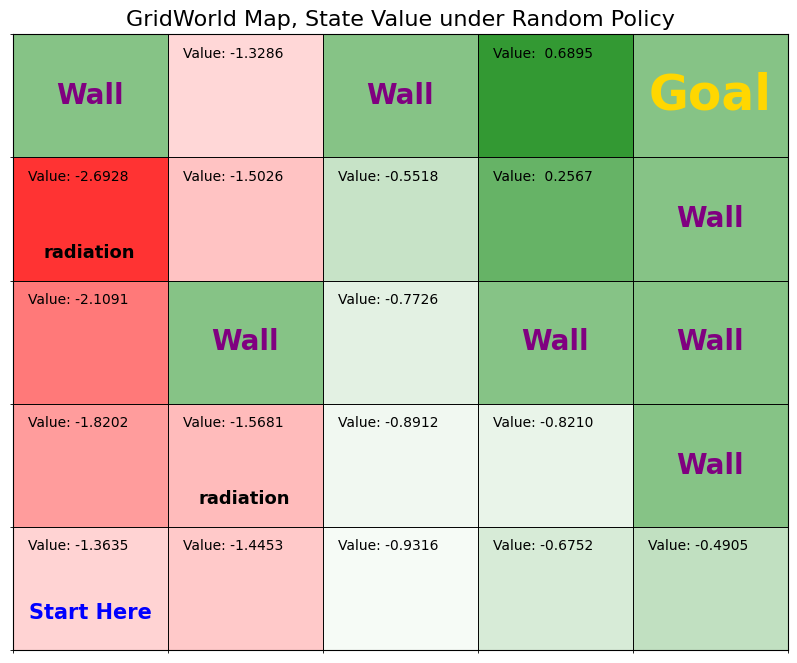

In [9]:
from collections import defaultdict

random_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
total_episode = 2000
alpha = 0.1

game = GridWorld(random_policy)

for _ in range(total_episode):

  current_state = game.start_state # (4, 0)

  while True:
    action = game.get_action(current_state)
    next_state = game.next_state(current_state, action)
    reward = game.reward_map[next_state]

    game.value_map[current_state] += alpha * (reward + game.gamma * game.value_map[next_state] - game.value_map[current_state])
    current_state = next_state

    if current_state == game.terminal_state:
      break

game.render()

---

## **Conclusion**

Using the value map, we estimated the value of each state through the one-step TD method. Although we ran approximately 2000 episodes, this should not be considered a completely converged result. However, the estimated values are very close to the true values, as verified in [03_GridWorld_DP.ipynb](https://github.com/LeeJunho-AI/Reinforcement_Learning_Study/blob/main/03_GridWorld_DP.ipynb).  

The key advantage of the TD method lies in its ability to update state values without requiring complete knowledge of the environment and without waiting for the episode to terminate. This makes TD a highly valuable approach in many applications.



<br>

---